In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'2.0.0'

In [0]:
# To generate GIFs
!pip install imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [0]:
#--------------------------------------------------------------------------------

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
newsize = (256, 256)
datas = []
for image_name in os.listdir("/content/drive/My Drive/dreams"):
  im = PIL.Image.open(os.path.join("/content/drive/My Drive/dreams", image_name))
  im = im.resize(newsize)
  data = np.asarray(im, dtype='float32')
  datas.append(data)
datas = np.asarray(datas)

KeyboardInterrupt: ignored

In [0]:
import pickle
datas = pickle.load( open( '/content/drive/My Drive/cpk/data.pickle', 'rb' ) )

In [0]:
datas.shape

(3801, 256, 256, 3)

In [0]:
import pickle
with open('/content/drive/My Drive/cpk/data.pickle', 'wb') as handle:
    pickle.dump(datas, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
train_images = (datas - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
train_images[0]

array([[[ 0.6627451 ,  0.78039217,  0.4745098 ],
        [ 0.60784316,  0.7254902 ,  0.41960785],
        [ 0.75686276,  0.8745098 ,  0.5686275 ],
        ...,
        [ 0.654902  ,  0.77254903,  0.04313726],
        [ 0.5921569 ,  0.7411765 ,  0.01960784],
        [ 0.44313726,  0.6313726 , -0.12156863]],

       [[ 0.7019608 ,  0.78039217,  0.49019608],
        [ 0.58431375,  0.6627451 ,  0.37254903],
        [ 0.6627451 ,  0.75686276,  0.45882353],
        ...,
        [ 0.54509807,  0.654902  , -0.09019608],
        [ 0.60784316,  0.7411765 , -0.01176471],
        [ 0.5921569 ,  0.7647059 , -0.00392157]],

       [[ 0.6784314 ,  0.70980394,  0.41960785],
        [ 0.6       ,  0.6313726 ,  0.35686275],
        [ 0.69411767,  0.7411765 ,  0.45882353],
        ...,
        [ 0.44313726,  0.5058824 , -0.27058825],
        [ 0.5921569 ,  0.6862745 , -0.09803922],
        [ 0.6862745 ,  0.81960785,  0.01960784]],

       ...,

       [[ 0.7176471 ,  0.9137255 ,  0.6       ],
        [ 0

In [0]:
BUFFER_SIZE = 3800
BATCH_SIZE = 64

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

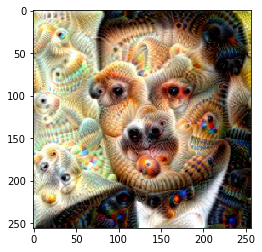

In [0]:
plt.imshow((train_images[0,:,:,:] + 1) /2)

In [0]:
#--------------------------------------------------------------------------------

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    init = tf.initializers.RandomNormal(mean=0.0, stddev=0.2)
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(256,), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 128, 128, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer=init))
    assert model.output_shape == (None, 256, 256, 3)

    return model

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 256])
generated_image = generator(noise, training=False)
(generated_image[0, :, :, :] + 1) / 2

<tf.Tensor: id=1340, shape=(256, 256, 3), dtype=float32, numpy=
array([[[1.0000000e+00, 9.8751438e-01, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 4.7683716e-07],
        [0.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [7.1589351e-03, 5.6453943e-03, 0.0000000e+00]],

       [[1.3368726e-03, 2.9802322e-08, 6.9949925e-03],
        [3.6290205e-01, 0.0000000e+00, 9.9999857e-01],
        [9.9999905e-01, 0.0000000e+00, 2.9802322e-08],
        ...,
        [1.0000000e+00, 0.0000000e+00, 1.0000000e+00],
        [0.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]],

       [[4.7683716e-07, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        ...,
        [1.0000000e+00, 1.0000000e+00, 0.0000000e+00],
        [2.57

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


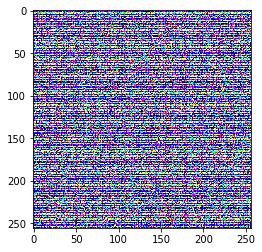

In [0]:
plt.imshow((generated_image[0, :, :, :] + 1) / 2)

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    init = tf.initializers.RandomNormal(mean=0.0, stddev=0.02)
    model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3], kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00064785]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 500
noise_dim = 256
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 10 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = "/content/drive/My Drive/cpk")

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] + 1) / 2)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

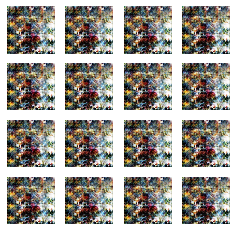

Time for epoch 21 is 130.8264238834381 sec


KeyboardInterrupt: ignored

In [0]:
train(train_dataset, EPOCHS)

In [0]:
import os
try:
  import shutil
except:
  pass
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

In [0]:
copytree(checkpoint_dir, "/content/drive/My Drive/cpk")

NameError: ignored

In [0]:
checkpoint.restore(tf.train.latest_checkpoint("/content/drive/My Drive/cpk"))

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

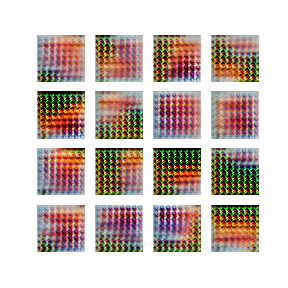

In [0]:
display_image(EPOCHS)

In [0]:
prediction = generator(seed, training=False)

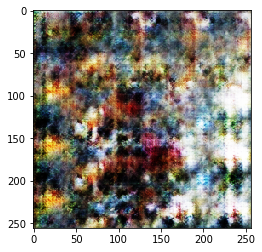

In [0]:
plt.imshow((prediction[0, :, :, :] + 1) / 2)